In [64]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime 


In [67]:
#读取数据
dateparser = lambda dates:datatime.strptime(data,'%Y%m%d')
data_csv = pd.read_csv('./399300.csv',date_parser=dateparser,encoding='GB2312')

In [68]:
#单位根校验、白噪声校验
from statsmodels.stats.diagnostic import  acorr_ljungbox
acorr_ljungbox(data_csv.price,lags=1) #大于0.05,为非白噪声

(array([4611.47383502]), array([0.]))

In [69]:
from statsmodels.tsa.stattools import  adfuller as ADF #ADF单位根校验
ADF(data_csv.price)

(-2.104853047833339,
 0.24256764980004358,
 32,
 4592,
 {'1%': -3.431774860464899,
  '5%': -2.8621696219375385,
  '10%': -2.5671051506350233},
 49281.676306169684)

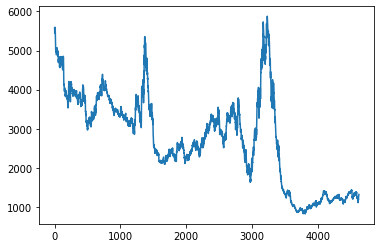

In [71]:
plt.plot(data_csv.price)

第二项： 0.242>0.05 因此为不平稳数据，尝试做差分处理。


In [72]:
diff1_result = data_csv.price.diff(1)


In [73]:
import numpy as np
diff1_result[np.isnan(diff1_result)]=0
diff1_result

0        0.0000
1       -4.8067
2      -88.5357
3      -38.9102
4       80.9971
         ...   
4620    31.4500
4621    -8.6100
4622    20.0600
4623     9.3700
4624    14.3800
Name: price, Length: 4625, dtype: float64

In [74]:
ADF(diff1_result) 

(-11.956816648312298,
 4.1910242246220877e-22,
 31,
 4593,
 {'1%': -3.4317745500669052,
  '5%': -2.862169484810712,
  '10%': -2.5671050776361515},
 49284.13759289995)

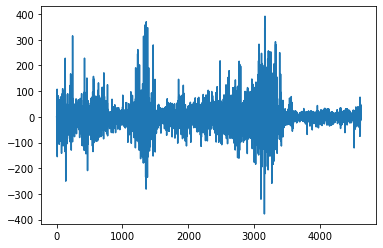

In [75]:
#第二项小于0.05，已为平稳序列！
#看一下图
plt.plot(diff1_result)

已经是平稳序列，尝试观察ACF PACF图，判断模型类型

In [76]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import  seasonal_decompose
from statsmodels.tsa.stattools import adfuller as ADF
from datetime import  datetime

def autocorrelation(timeseries,lags):
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    sm.graphics.tsa.plot_acf(timeseries,lags=lags,ax=ax1)
    ax2 = fig.add_subplot(212)
    sm.graphics.tsa.plot_pacf(timeseries,lags=lags,ax=ax2)
    plt.show()

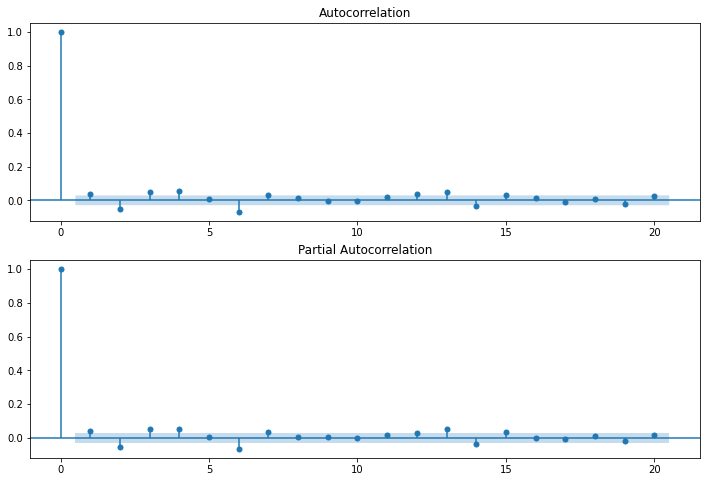

In [77]:
autocorrelation(diff1_result,20)

可以看出，不存在明显的截尾或拖尾。说明对于这样的序列，并不适合用ARIMA 模型来拟合。如何用 ARIMA 模型来拟合这样的曲线呢？这里先通过对时间序列分解，观察。

In [78]:
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller as ADF



def decomposing(timeseries):
    decomposition = seasonal_decompose(timeseries)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.figure(figsize=(16, 12))
    plt.subplot(411)
    plt.plot(timeseries, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal, label='Seasonarity')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residual')
    plt.legend(loc='best')
    plt.show()


In [81]:
from datetime import  datetime
dateparser = lambda dates:datetime.strptime(dates,'%Y/%m/%d')
data_csv = pd.read_csv('./399300.csv',index_col='time',date_parser=dateparser,encoding='GB2312')
data_csv = data_csv[0:60]
data_csv.head()

,股票代码,名称,price,最高价,最低价,开盘价,前收盘,涨跌额,涨跌幅,成交量,成交金额
time,,,,,,,,,,,
2021-01-22,'399300,沪深300,5569.7760,5573.6594,5513.8769,5562.3790,5564.9693,4.8067,0.0864,19930002000,4.570000e+11
2021-01-21,'399300,沪深300,5564.9693,5593.1058,5490.5626,5492.9587,5476.4336,88.5357,1.6167,20995019700,4.530000e+11
2021-01-20,'399300,沪深300,5476.4336,5496.0493,5426.5357,5439.9111,5437.5234,38.9102,0.7156,17091326000,3.740000e+11
2021-01-19,'399300,沪深300,5437.5234,5532.4793,5415.7166,5525.9690,5518.5205,-80.9971,-1.4677,21104342500,4.330000e+11
2021-01-18,'399300,沪深300,5518.5205,5541.4613,5410.7750,5438.1618,5458.0812,60.4393,1.1073,20705186900,4.230000e+11


In [82]:
data_csv = data_csv.sort_index()
data_csv=data_csv.asfreq('D')

In [86]:
data_csv.head()

,股票代码,名称,price,最高价,最低价,开盘价,前收盘,涨跌额,涨跌幅,成交量,成交金额
time,,,,,,,,,,,
2020-10-30,'399300,沪深300,4695.3338,4778.5089,4683.4719,4776.4726,4772.9198,-77.586,-1.6255,1.398023e+10,2.810000e+11
2020-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-11-02,'399300,沪深300,4720.8313,4738.0239,4695.4436,4702.7457,4695.3338,25.4975,0.543,1.428677e+10,2.790000e+11
2020-11-03,'399300,沪深300,4777.5608,4793.3963,4734.1748,4743.1742,4720.8313,56.7295,1.2017,1.360554e+10,2.520000e+11


In [87]:
import numpy as np
data_csv = data_csv.replace(np.NAN,0)

In [88]:
data_csv.head()

,股票代码,名称,price,最高价,最低价,开盘价,前收盘,涨跌额,涨跌幅,成交量,成交金额
time,,,,,,,,,,,
2020-10-30,'399300,沪深300,4695.3338,4778.5089,4683.4719,4776.4726,4772.9198,-77.586,-1.6255,1.398023e+10,2.810000e+11
2020-10-31,0,0,0.0000,0.0000,0.0000,0.0000,0,0,0,0.000000e+00,0.000000e+00
2020-11-01,0,0,0.0000,0.0000,0.0000,0.0000,0,0,0,0.000000e+00,0.000000e+00
2020-11-02,'399300,沪深300,4720.8313,4738.0239,4695.4436,4702.7457,4695.3338,25.4975,0.543,1.428677e+10,2.790000e+11
2020-11-03,'399300,沪深300,4777.5608,4793.3963,4734.1748,4743.1742,4720.8313,56.7295,1.2017,1.360554e+10,2.520000e+11


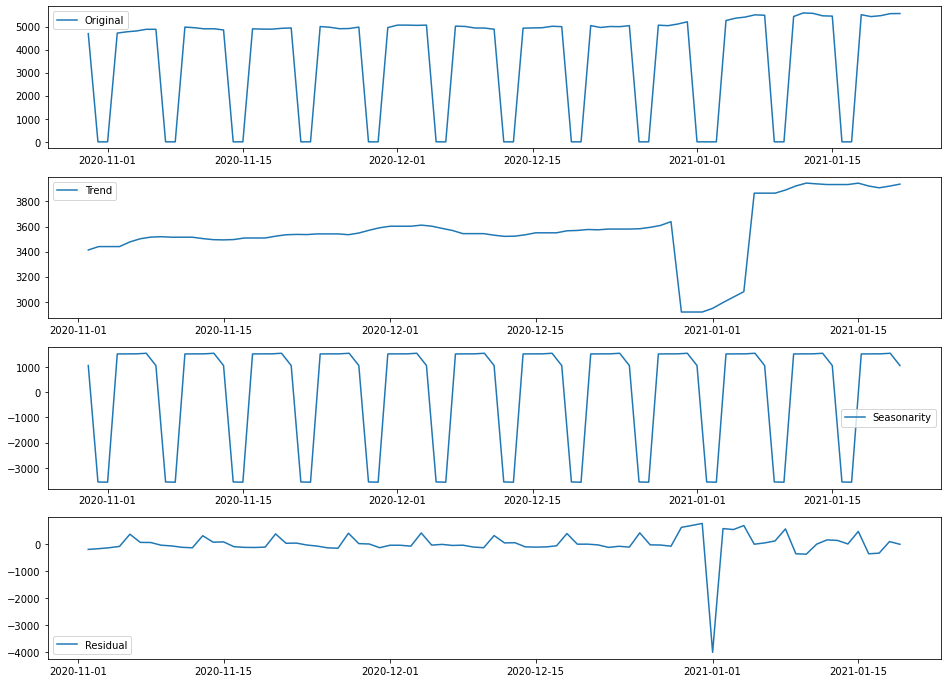

In [89]:
decomposing(data_csv.price)

In [90]:
decomposition = seasonal_decompose(data_csv.price)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

In [91]:
def diff(timeseries):
    timeseries_diff1 = timeseries.diff(1)
    timeseries_diff2 = timeseries_diff1.diff(1)

    timeseries_diff1 = timeseries_diff1.fillna(0)
    timeseries_diff2 = timeseries_diff2.fillna(0)


    timeseries_adf = ADF(timeseries.tolist())
    timeseries_diff1_adf = ADF(timeseries_diff1.tolist())
    timeseries_diff2_adf = ADF(timeseries_diff2.tolist())

    print('timeseries_adf : ', timeseries_adf)
    print('timeseries_diff1_adf : ', timeseries_diff1_adf)
    print('timeseries_diff2_adf : ', timeseries_diff2_adf)

    plt.figure(figsize=(12, 8))
    plt.plot(timeseries, label='Original', color='blue')
    plt.plot(timeseries_diff1, label='Diff1', color='red')
    plt.plot(timeseries_diff2, label='Diff2', color='purple')
    plt.legend(loc='best')
    plt.show()

In [92]:
trend = trend.fillna(0)
trend = trend[0:60]

In [94]:
#白噪声校验 >0.05 为非白噪声
acorr_ljungbox(trend,lags=1)

(array([29.03129958]), array([7.12182695e-08]))

In [95]:
trend_diff1 = trend.diff(1)

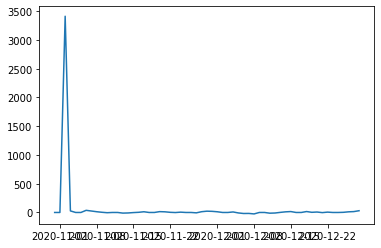

In [96]:
plt.plot(trend_diff1)

In [97]:

trend_evaluate = sm.tsa.arma_order_select_ic(trend, ic=['aic', 'bic'], trend='nc', max_ar=5,
                                            max_ma=5)
print('trend AIC', trend_evaluate.aic_min_order)
print('trend BIC', trend_evaluate.bic_min_order)


C:\Users\Owen\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\Owen\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\Owen\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\Owen\Anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\

trend AIC (1, 0)
trend BIC (1, 0)


C:\Users\Owen\Anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [58]:
trend

time
2020-10-30       0.000000
2020-10-31       0.000000
2020-11-01       0.000000
2020-11-02    3413.213443
2020-11-03    3440.411157
2020-11-04    3440.411157
2020-11-05    3440.411157
2020-11-06    3477.628071
2020-11-07    3502.815900
2020-11-08    3515.850429
2020-11-09    3519.186314
2020-11-10    3515.062529
2020-11-11    3515.062529
2020-11-12    3515.062529
2020-11-13    3504.037086
2020-11-14    3495.595714
2020-11-15    3493.706214
2020-11-16    3496.495657
2020-11-17    3508.843786
2020-11-18    3508.843786
2020-11-19    3508.843786
2020-11-20    3523.251743
2020-11-21    3534.608814
2020-11-22    3537.327157
2020-11-23    3536.127457
2020-11-24    3541.481286
2020-11-25    3541.481286
2020-11-26    3541.481286
2020-11-27    3535.084800
2020-11-28    3548.343771
2020-11-29    3570.693014
2020-11-30    3590.331457
2020-12-01    3602.495929
2020-12-02    3602.495929
2020-12-03    3602.495929
2020-12-04    3611.350671
2020-12-05    3603.176429
2020-12-06    3585.398414
2020-12

In [98]:
def ARIMA_Model(timeseries, order):
    model = ARIMA(timeseries, order=order)
    return model.fit(disp=0)

trend_model = ARIMA_Model(trend,(1,0,0))
trend_fit_seq = trend_model.fittedvalues
trend_predict_seq = trend_model.predict(start='2020-12-28',end='2021-01-30',dynamic=True)

In [99]:
trend_model.summary2() #模型报告

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: ARMA
====================================================================
Model:              ARMA             BIC:                 915.2186  
Dependent Variable: price            Log-Likelihood:      -451.47   
Date:               2021-01-27 14:45 Scale:               1.0000    
No. Observations:   60               Method:              css-mle   
Df Model:           2                Sample:              10-30-2020
Df Residuals:       58                                    12-28-2020
Converged:          1.0000           S.D. of innovations: 440.789   
No. Iterations:     31.0000          HQIC:                911.393   
AIC:                908.9356                                        
--------------------------------------------------------------------
                 Coef.   Std.Err.    t    P>|t|    [0.025    0.975] 
--------------------------------------------------------------------
const          2877.3019 769.3808  3.7398 0.0004 1369.3433 4385.2604
ar.L1.price       0.9324   0.0618 15.0950 0.0000    0.8113    1.0534
-----------------------------------------------------------------------------
                 Real           Imaginary          Modulus          Frequency
-----------------------------------------------------------------------------
AR.1            1.0725             0.0000           1.0725             0.0000
====================================================================

"""

In [101]:
trend_predict_seq

2020-12-28    3559.531340
2020-12-29    3513.395932
2020-12-30    3470.380406
2020-12-31    3430.273782
2021-01-01    3392.879348
2021-01-02    3358.013692
2021-01-03    3325.505809
2021-01-04    3295.196253
2021-01-05    3266.936366
2021-01-06    3240.587538
2021-01-07    3216.020536
2021-01-08    3193.114865
2021-01-09    3171.758177
2021-01-10    3151.845724
2021-01-11    3133.279841
2021-01-12    3115.969465
2021-01-13    3099.829695
2021-01-14    3084.781368
2021-01-15    3070.750676
2021-01-16    3057.668802
2021-01-17    3045.471584
2021-01-18    3034.099195
2021-01-19    3023.495859
2021-01-20    3013.609567
2021-01-21    3004.391831
2021-01-22    2995.797439
2021-01-23    2987.784239
2021-01-24    2980.312927
2021-01-25    2973.346858
2021-01-26    2966.851866
2021-01-27    2960.796095
2021-01-28    2955.149842
2021-01-29    2949.885414
2021-01-30    2944.976990
Freq: D, dtype: float64